In [1]:
import numpy
import pandas
import seaborn
import logging
import time
import collections
import os
from os import environ
from matplotlib import pyplot

import sklearn
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.linear_model

from six import string_types

import mhcflurry
import mhcnames

%matplotlib inline
logging.basicConfig(level="DEBUG")

pandas.set_option('display.max_columns', 60)

from mhc2flurry.downloads import get_path
from mhcflurry.common import random_peptides
import mhc2flurry

from copy import deepcopy
from mhcflurry.regression_target import from_ic50, to_ic50
import shutil
from Bio import SeqIO
import bz2

import tensorflow as tf
#config = tf.ConfigProto(allow_soft_placement=True, log_device_placement=True)
#session = tf.Session(config=config)
#K.set_session(session)

def ppv(y_true, predictions):
    df = pandas.DataFrame({"prediction": predictions, "y_true": y_true})
    return df.sort_values("prediction", ascending=False)[:int(y_true.sum())].y_true.mean()

import Bio.SeqIO
import traceback
from gzip import GzipFile
import Bio
import Bio.SeqUtils
from glob import glob
import json
from scipy.stats import pearsonr

import tqdm

from notebook.services.config import ConfigManager
c = ConfigManager()
c.update('notebook', {"CodeCell": {"cm_config": {"autoCloseBrackets": False}}})

import mhcgnomes

import mhc2flurry.allele_encoding_pair
import mhc2flurry.allele_encoding

In [2]:
!ls "$(mhc2flurry-downloads path data_curated)"

DOWNLOAD_INFO.csv
GENERATE.sh
LOG.txt.bz2
curate.py
curate_ms_by_pmid.py
curated_training_data.affinity.csv.bz2
curated_training_data.csv.bz2
curated_training_data.mass_spec.csv.bz2
curated_training_data.no_additional_ms.csv.bz2
expression
ms.by_pmid.csv.bz2
rna_expression.csv.bz2
rna_expression.metadata.csv.bz2


In [3]:
train_df = pandas.read_csv(get_path("data_curated", "curated_training_data.csv.bz2"))
train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
...,...,...,...,...,...,...,...,...
311334,Mamu-DRB1*04:06,YKTIAFDEEARR,5000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311335,Mamu-DRB1*04:06,YLCLIQKALFMHCKK,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311336,Mamu-DRB1*04:06,YVPHFKVGWAWWTCS,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311337,Patr-DRB1*03:08,KTIAYDEEARR,100.0,<,qualitative,affinity,Bontrop - cellular MHC/direct/fluorescence,Patr-DRB1*03:08


In [4]:
train_ms_df = pandas.read_csv(get_path("data_curated", "ms.by_pmid.csv.bz2"))
train_ms_df = train_ms_df.loc[
    train_ms_df.mhc_class == "II"
]
train_ms_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,intensity,original_pmid,pulldown_antibody,sample_type
0,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
1,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
2,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
3,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
4,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293
...,...,...,...,...,...,...,...,...,...,...,...,...
297642,31611696,3912_BAM-HLA-DR-DEPLETED,YYYIQQDTKGDYQKA,DR-DEPLETED,II,HLA-DRB1*03:01 HLA-DRB1*04:01 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,23.62321,31611696,NaN,MENINGIOMA
297643,31611696,4052_BA-HLA-DR,YYYIQQDTKGDYQKA,DR-SPECIFIC,II,HLA-DRB1*03:01 HLA-DRB1*11:04 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,30.98475,31611696,HB298,MENINGIOMA
297644,31611696,4052_BA-HLA-DR-DEPLETED,YYYIQQDTKGDYQKA,DR-DEPLETED,II,HLA-DRB1*03:01 HLA-DRB1*11:04 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,22.62017,31611696,NaN,MENINGIOMA
297645,31611696,3912_BAM-HLA-DR,YYYIQQDTKGDYQKAL,DR-SPECIFIC,II,HLA-DRB1*03:01 HLA-DRB1*04:01 HLA-DRB3*01:01 H...,sample_type:MENINGIOMA,NaN,28.35611,31611696,HB298,MENINGIOMA


In [5]:
affinity_df = train_df.loc[
    (~train_df.peptide.isin(train_ms_df.peptide)) &
    (train_df.measurement_kind == "affinity")
]
affinity_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
...,...,...,...,...,...,...,...,...
311334,Mamu-DRB1*04:06,YKTIAFDEEARR,5000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311335,Mamu-DRB1*04:06,YLCLIQKALFMHCKK,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311336,Mamu-DRB1*04:06,YVPHFKVGWAWWTCS,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311337,Patr-DRB1*03:08,KTIAYDEEARR,100.0,<,qualitative,affinity,Bontrop - cellular MHC/direct/fluorescence,Patr-DRB1*03:08


In [6]:
allele_sequences_alpha = pandas.read_csv(
    get_path("allele_sequences", "alpha.csv"), index_col=0)
allele_sequences_alpha = pandas.Series([
    "".join(row)
    for (allele, row) in allele_sequences_alpha.iterrows()
], index=allele_sequences_alpha.index)
allele_sequences_alpha

allele_sequences_beta = pandas.read_csv(
    get_path("allele_sequences", "beta.csv"), index_col=0)
allele_sequences_beta = pandas.Series([
    "".join(row)
    for (allele, row) in allele_sequences_beta.iterrows()
], index=allele_sequences_beta.index)
allele_sequences_beta

HLA-DPB1*01:01     XXXMMVLQVSAAPRTVALTALLMVLLTSVVQGRATPENYVYQGRQE...
HLA-DPB1*02:01     XXXMMVLQVSAAPRTVALTALLMVLLTSVVQGRATPENYLFQGRQE...
HLA-DPB1*02:01Q    XXXMMVLQVSAAPRTVALTALLMVLLTSVVQGRATPENYLFQGRQE...
HLA-DPB1*02:02     XXXMMVLQVSAAPRTVALTALLMVLLTSVVQGRATPENYLFQGRQE...
HLA-DPB1*03:01     XXXMMVLQVSAAPRTVALTALLMVLLTSVVQGRATPENYVYQLRQE...
                                         ...                        
HLA-DRB5*01:99     XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXRFLQQDKYE...
HLA-DRB5*02:02     XXXMVCLKLPGGSYMAVLTVTLMVLSSPLALAGDTRPCFLQQDKYE...
HLA-DRB5*02:03     XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCFLQQDKYE...
HLA-DRB5*02:21     XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCFLQQDKYE...
HLA-DRB5*02:22     XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXCFLQQDKYE...
Length: 1159, dtype: object

In [7]:
mhcgnomes.parse("Patr-DRB1*03:08", infer_class2_pairing=True)

Allele(gene=Gene(species=Species(name='Pan troglodytes', mhc_prefix='Patr'), name='DRB1'), allele_fields=('03', '08'), annotations=(), mutations=())

In [8]:
mhcgnomes.parse("HLA-DRB1*03:08", infer_class2_pairing=True)

Class2Pair(alpha=Allele(gene=Gene(species=Species(name='Homo sapiens', mhc_prefix='HLA'), name='DRA'), allele_fields=('01', '01'), annotations=(), mutations=()), beta=Allele(gene=Gene(species=Species(name='Homo sapiens', mhc_prefix='HLA'), name='DRB1'), allele_fields=('03', '08'), annotations=(), mutations=()), mhc_class='IIa')

In [9]:
train_df.loc[
    ~train_df.peptide.isin(train_ms_df.peptide)
]

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01
...,...,...,...,...,...,...,...,...
311334,Mamu-DRB1*04:06,YKTIAFDEEARR,5000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311335,Mamu-DRB1*04:06,YLCLIQKALFMHCKK,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311336,Mamu-DRB1*04:06,YVPHFKVGWAWWTCS,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06
311337,Patr-DRB1*03:08,KTIAYDEEARR,100.0,<,qualitative,affinity,Bontrop - cellular MHC/direct/fluorescence,Patr-DRB1*03:08


In [10]:
train_df["parsed_allele"] = train_df.allele.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True))
train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,parsed_allele
0,BoLA-DRB3*001:01,AYAAQGYKVLVLNPSVAA,1541.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
1,BoLA-DRB3*001:01,CGKYLFNWAVRTKLKLTPIA,8776.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
2,BoLA-DRB3*001:01,ENLPYLVAYQATVCARAQAP,36805.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
3,BoLA-DRB3*001:01,GIQYLAGLSTLPGNPAIASL,100000.0,>,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
4,BoLA-DRB3*001:01,KGGRKPARLIVFPDLGVRVC,3336.0,=,quantitative,affinity,Walker - purified MHC/competitive/radioactivity,BoLA-DRB3*001:01,Allele(gene=Gene(species=Species(name='Bos sp....
...,...,...,...,...,...,...,...,...,...
311334,Mamu-DRB1*04:06,YKTIAFDEEARR,5000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311335,Mamu-DRB1*04:06,YLCLIQKALFMHCKK,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311336,Mamu-DRB1*04:06,YVPHFKVGWAWWTCS,1000.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,Mamu-DRB1*04:06,Allele(gene=Gene(species=Species(name='Macaca ...
311337,Patr-DRB1*03:08,KTIAYDEEARR,100.0,<,qualitative,affinity,Bontrop - cellular MHC/direct/fluorescence,Patr-DRB1*03:08,Allele(gene=Gene(species=Species(name='Pan tro...


In [11]:
use_train_df = train_df.loc[train_df.parsed_allele.map(lambda p: isinstance(p, mhcgnomes.Class2Pair))].copy()
use_train_df["alpha_allele"] = use_train_df.parsed_allele.map(lambda p: p.alpha.to_string())
use_train_df["beta_allele"] = use_train_df.parsed_allele.map(lambda p: p.beta.to_string())

use_train_df = use_train_df.loc[
    (use_train_df.alpha_allele.isin(allele_sequences_alpha.index)) &
    (use_train_df.beta_allele.isin(allele_sequences_beta.index))
].copy()

use_train_df = use_train_df.loc[
    (use_train_df.measurement_kind == "affinity")
].copy()
use_train_df["allele"] = use_train_df.allele.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True).to_string())
use_train_df

,allele,peptide,measurement_value,measurement_inequality,measurement_type,measurement_kind,measurement_source,original_allele,parsed_allele,alpha_allele,beta_allele
9944,HLA-DPA1*01:03-DPB1*02:01,AAAAGWQTLSAALDA,3770.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9946,HLA-DPA1*01:03-DPB1*02:01,AAAGAEAGKATTEEQ,46700.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9961,HLA-DPA1*01:03-DPB1*02:01,AAASVPAADKFKTFE,5520.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9962,HLA-DPA1*01:03-DPB1*02:01,AAATATATAAVGAAT,46700.0,>,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
9964,HLA-DPA1*01:03-DPB1*02:01,AADHAAPEDKYEAFV,781.0,=,quantitative,affinity,Sette - purified MHC/competitive/radioactivity,HLA-DPA1*01:03/DPB1*02:01,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DPA1*01:03,HLA-DPB1*02:01
...,...,...,...,...,...,...,...,...,...,...,...
309988,HLA-DRA*01:01-DRB5*01:02,VSILQTASSGLTSLTNSLQR,5000.0,<,qualitative,affinity,Robinson - purified MHC/direct/fluorescence,HLA-DRB5*01:02,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
309989,HLA-DRA*01:01-DRB5*01:02,VTAVFGSSTAGTGTAASPSF,5000.0,<,qualitative,affinity,Robinson - purified MHC/direct/fluorescence,HLA-DRB5*01:02,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
309990,HLA-DRA*01:01-DRB5*01:02,VTPRTPPPSQGKGRGLSLSR,20000.0,>,quantitative,affinity,Adorini - purified MHC/competitive/radioactivity,HLA-DRB5*01:02,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02
309991,HLA-DRA*01:01-DRB5*01:02,YKSAHKGFKGVDAQGTLSKI,4100.0,=,quantitative,affinity,Adorini - purified MHC/competitive/radioactivity,HLA-DRB5*01:02,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB5*01:02


In [12]:
use_train_df.allele.value_counts()

HLA-DRA*01:01-DRB1*01:01     10624
HLA-DRA*01:01-DRB1*04:01      6075
HLA-DRA*01:01-DRB1*03:01      5189
HLA-DRA*01:01-DRB1*07:01      5068
HLA-DRA*01:01-DRB1*11:01      5054
                             ...  
HLA-DPA1*01:03-DPB1*11:01        2
HLA-DRA*01:01-DRB1*03:04         1
HLA-DRA*01:01-DRB1*13:05         1
HLA-DRA*01:01-DRB1*04:08         1
HLA-DQA1*01:01-DQB1*05:03        1
Name: allele, Length: 102, dtype: int64

In [13]:
validation_df = train_ms_df.loc[
    (train_ms_df.format == "MONOALLELIC") &
    (~train_ms_df.peptide.isin(use_train_df.peptide))
].copy()
validation_df["parsed_allele"] = validation_df.hla.map(lambda s: mhcgnomes.parse(s, infer_class2_pairing=True))

validation_df = validation_df.loc[validation_df.parsed_allele.map(lambda p: isinstance(p, mhcgnomes.Class2Pair))].copy()
validation_df["alpha_allele"] = validation_df.parsed_allele.map(lambda p: p.alpha.to_string())
validation_df["beta_allele"] = validation_df.parsed_allele.map(lambda p: p.beta.to_string())

validation_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,intensity,original_pmid,pulldown_antibody,sample_type,parsed_allele,alpha_allele,beta_allele
0,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
1,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
2,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
3,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
4,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,31495665,MAPTAC_DRB1*15:01,AQNVGTTHDL,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
45632,31495665,MAPTAC_DRB1*15:01,YPHRPVLMVISHAAPHGPE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
45633,31495665,MAPTAC_DRB1*15:01,KQERISRYQGVNLYIKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01
45634,31495665,MAPTAC_DRB1*15:01,QDEHFLGIESLWNHKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01


In [14]:
validation_df.hla.value_counts()

HLA-DRA*01:01-DRB1*11:01     10021
HLA-DRA*01:01-DRB1*01:01      8032
HLA-DPA1*01:03-DPB1*06:01     5960
HLA-DRA*01:01-DRB1*07:01      5685
HLA-DRA*01:01-DRB1*15:01      3428
HLA-DRA*01:01-DRB3*01:01      2612
HLA-DRA*01:01-DRB1*03:01      2590
HLA-DRA*01:01-DRB1*12:01      2500
HLA-DRA*01:01-DRB1*04:01      2446
HLA-DQA1*01:02-DQB1*06:04     2219
Name: hla, dtype: int64

In [15]:
allele = "HLA-DRA*01:01-DRB1*01:01"
validation_df.loc[validation_df.hla == allele].shape, use_train_df.loc[use_train_df.allele == allele].shape

((8032, 15), (10624, 11))

In [16]:
allele_sequences_alpha.to_dict()

{'HLA-DPA1*01:03': 'MRPEDRMFHIRAVILRALSLAFLLSLRGAGAIKADHVSTYAXAFVQTHRPTGEFMFEFDEDEMFYVDLDKKETVWHLEEFGQAFSFEAQGGLANIAILNNNLNTLIQRSNHTQATNDPPEVTVFPKEPVELGQPNTLICHIDKFFPPVLNVTWLCNGELVTEGVAESLFLPRTDYSFHKFHYLTFVPSAEDFYDCRVEHWGLDQPLLKHWEAQEPIQMPETTETVLCALGLVLGLVGIIVGTVLIIKSLRSGHDPRAQGTL',
 'HLA-DPA1*01:03Q': 'MRPEDRMFHIRAVILRALSLAFLLSLRGAGAIKADHVSTYAXAFVQTHRPTGEFMFEFDEDEMFYVDLDKKETVWHLEEFGQAFSFEAQGGLANIAILNNNLNTLIQRSNHTQATNDPPEVTVFPKEPVELGQPNTLICHIDKFFPPVLNVTWLCNGELVTEGVAESLFLPRTDYSFHKFHYLTFVPSAEDFYDCRVEHWGLDQPLLKHWEAQEPIQMPETTETVLCALGLVLGLVGIIVGTVLIIKSLRSGHDPRAQGTL',
 'HLA-DPA1*01:04': 'XXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXDHVSTYAXAFVQTHRPTGEFMFEFDDDEMFYVDLDKKETVWHLEEFGQAFSFEAQGGLANIAILNNNLNTLIQRSNHTQATNDPPEVTVFPKEPVELGQPNTLICHIDKFFPPVLNVTWLCNGELVTEGVAESLFLPRTDYSFHKFHYLTFVPSAEDFYDCRVEHWGLDQPLLKHWEAQEPIQMPETTETVLCALGLVLGLVGIIVGTVLIIKSLRSGHDPRAQGTL',
 'HLA-DPA1*01:14': 'MRPEDRMFHIRAVILRALSLAFLLSLRGAGAIKADHVSTYAXAFVQTHRPTGEFMFEFDEDEMFYVDLDKKETVWHLEEFGQAFSFEAQGGLANIAILNNNLNTLIQRSNHTQATNDPPEVTVFPKE

In [17]:
import mhc2flurry.allele_encoding_pair
import mhc2flurry.allele_encoding

allele_encoding_pair = mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_train_df.alpha_allele.values,
        allele_to_sequence=allele_sequences_alpha.to_dict()),
    mhc2flurry.allele_encoding.AlleleEncoding(
        use_train_df.beta_allele.values,
        allele_to_sequence=allele_sequences_beta.to_dict()))
allele_encoding_pair

In [19]:
import imp
import mhc2flurry.condconv
imp.reload(mhc2flurry.condconv)

import mhc2flurry.class2_neural_network
imp.reload(mhc2flurry.class2_neural_network)
import mhc2flurry.class2_neural_network


model = mhc2flurry.class2_neural_network.Class2NeuralNetwork(
    random_negative_rate=1.0,
    layer_sizes=[8],
    patience=5,
    peptide_convolutions=[
        {'kernel_size': 9, 'filters': 64, 'activation': "relu"},
        {'kernel_size': 1, 'filters': 16, 'activation': "relu"},
        {'kernel_size': 16, 'filters': 16, 'activation': "relu"},
    ],
)
print(model.hyperparameters)

model.fit(
    use_train_df.peptide.values,
    affinities=from_ic50(use_train_df["measurement_value"].values),
    inequalities=use_train_df["measurement_inequality"].values,
    allele_encoding_pair=allele_encoding_pair
)

{'random_negative_rate': 1.0, 'layer_sizes': [8], 'patience': 5, 'peptide_convolutions': [{'kernel_size': 9, 'filters': 64, 'activation': 'relu'}, {'kernel_size': 1, 'filters': 16, 'activation': 'relu'}, {'kernel_size': 16, 'filters': 16, 'activation': 'relu'}], 'allele_amino_acid_encoding': 'BLOSUM62', 'allele_dense_layer_sizes': [], 'allele_positionwise_embedding_size': 32, 'peptide_encoding': {'vector_encoding_name': 'BLOSUM62', 'alignment_method': 'right_pad', 'max_length': 50}, 'dense_layer_l1_regularization': 0.001, 'dense_layer_l2_regularization': 0.0, 'activation': 'tanh', 'init': 'glorot_uniform', 'output_activation': 'sigmoid', 'dropout_probability': 0.0, 'batch_normalization': False, 'topology': 'feedforward', 'num_outputs': 1, 'loss': 'custom:mse_with_inequalities', 'optimizer': 'rmsprop', 'learning_rate': None, 'max_epochs': 500, 'validation_split': 0.1, 'early_stopping': True, 'minibatch_size': 128, 'data_dependent_initialization_method': None, 'random_negative_affinity_m

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpac98tjkf.py, line 18)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmpac98tjkf.py, line 18)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Instructions for updating:
non-resource variables are not supported in the long term



Forcing tensorflow backend.
1342/1342 [==============================] - 52s 39ms/step - loss: 0.2110 - output_loss: 0.0162 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.2057 - val_output_loss: 0.0354 - val_allele_dense_final_loss: 0.0000e+00
Epoch   0 / 500 [60.83 sec]: loss=0.211017. Min val loss (None) at epoch None
Epoch 2/2
1342/1342 [==============================] - 51s 38ms/step - loss: 0.1851 - output_loss: 0.0155 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.2048 - val_output_loss: 0.0346 - val_allele_dense_final_loss: 0.0000e+00
Epoch   1 / 500 [51.61 sec]: loss=0.185078. Min val loss (0.20565928518772125) at epoch 0
Epoch 3/3
1342/1342 [==============================] - 47s 35ms/step - loss: 0.1846 - output_loss: 0.0151 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.2036 - val_output_loss: 0.0334 - val_allele_dense_final_loss: 0.0000e+00
Epoch   2 / 500 [47.71 sec]: loss=0.18458. Min val loss (0.2047577202320099) at epoch 1
Epoch 4/4
1342/1342 [============

1342/1342 [==============================] - 46s 35ms/step - loss: 0.1817 - output_loss: 0.0123 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.1996 - val_output_loss: 0.0295 - val_allele_dense_final_loss: 0.0000e+00
Epoch  25 / 500 [46.62 sec]: loss=0.181712. Min val loss (0.1996728628873825) at epoch 20
Epoch 27/27
1342/1342 [==============================] - 50s 37ms/step - loss: 0.1817 - output_loss: 0.0123 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.2004 - val_output_loss: 0.0303 - val_allele_dense_final_loss: 0.0000e+00
Epoch  26 / 500 [50.47 sec]: loss=0.181679. Min val loss (0.1995829939842224) at epoch 25
Epoch 28/28
1342/1342 [==============================] - 49s 36ms/step - loss: 0.1817 - output_loss: 0.0122 - allele_dense_final_loss: 0.0000e+00 - val_loss: 0.2003 - val_output_loss: 0.0302 - val_allele_dense_final_loss: 0.0000e+00
Epoch  27 / 500 [48.94 sec]: loss=0.181653. Min val loss (0.1995829939842224) at epoch 25
Epoch 29/29
1342/1342 [====================

In [20]:
validation_allele_encoding_pair = mhc2flurry.allele_encoding_pair.AlleleEncodingPair(
    mhc2flurry.allele_encoding.AlleleEncoding(
        validation_df.alpha_allele.values,
        allele_to_sequence=allele_sequences_alpha.to_dict()),
    mhc2flurry.allele_encoding.AlleleEncoding(
        validation_df.beta_allele.values,
        allele_to_sequence=allele_sequences_beta.to_dict()))

validation_df["prediction"] = to_ic50(
    model.predict(
        validation_df.peptide.values,
        allele_encoding_pair=validation_allele_encoding_pair))
validation_df

,pmid,sample_id,peptide,format,mhc_class,hla,expression_dataset,cell_line,intensity,original_pmid,pulldown_antibody,sample_type,parsed_allele,alpha_allele,beta_allele,prediction
0,31495665,MAPTAC_DRB1*12:01_DM-,APVKKLVVKGGKKKKQVLKFTLD,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,3110.408732
1,31495665,MAPTAC_DRB1*12:01_DM-,VPGPGPAPMPSDFQVLRAKY,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,5459.134396
2,31495665,MAPTAC_DRB1*12:01_DM-,IGNLMVSPPVKVQGKE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,71.143457
3,31495665,MAPTAC_DRB1*12:01_DM-,ALMGYATHKYLDSEEDEE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,1043.464249
4,31495665,MAPTAC_DRB1*12:01_DM-,GSDQSENVDRGAGSIREA,MONOALLELIC,II,HLA-DRA*01:01-DRB1*12:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*12:01,2302.268741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45631,31495665,MAPTAC_DRB1*15:01,AQNVGTTHDL,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,3195.905025
45632,31495665,MAPTAC_DRB1*15:01,YPHRPVLMVISHAAPHGPE,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,197.851679
45633,31495665,MAPTAC_DRB1*15:01,KQERISRYQGVNLYIKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,46.000376
45634,31495665,MAPTAC_DRB1*15:01,QDEHFLGIESLWNHKN,MONOALLELIC,II,HLA-DRA*01:01-DRB1*15:01,cell_line:EXPI293,EXPI293,NaN,31495665,MAPTAC,EXPI293,Class2Pair(alpha=Allele(gene=Gene(species=Spec...,HLA-DRA*01:01,HLA-DRB1*15:01,2138.957030


,allele,auc
1,HLA-DQA1*01:02-DQB1*06:04,0.387751
3,HLA-DRA*01:01-DRB1*03:01,0.415763
9,HLA-DRA*01:01-DRB3*01:01,0.416378
0,HLA-DPA1*01:03-DPB1*06:01,0.444520
4,HLA-DRA*01:01-DRB1*04:01,0.452584
7,HLA-DRA*01:01-DRB1*12:01,0.509353
6,HLA-DRA*01:01-DRB1*11:01,0.524570
8,HLA-DRA*01:01-DRB1*15:01,0.546422
2,HLA-DRA*01:01-DRB1*01:01,0.558571
5,HLA-DRA*01:01-DRB1*07:01,0.559711


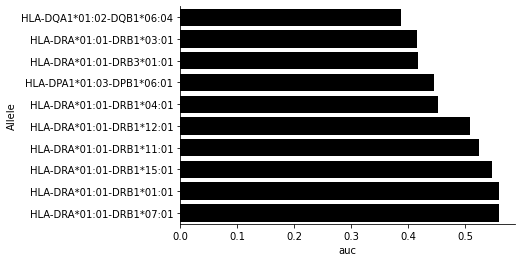

In [21]:
scores_df = []
to_score = validation_df.copy()
for allele, sub_validation_df in validation_df.groupby("hla"):
    to_score["hit"] = 0
    to_score.loc[sub_validation_df.index, "hit"] = 1
    scores_df.append((
        allele,
        sklearn.metrics.roc_auc_score(to_score.hit, -1 * to_score.prediction),
    ))

scores_df = pandas.DataFrame(scores_df, columns=["allele", "auc"])
scores_df = scores_df.sort_values("auc")

seaborn.barplot(data=scores_df, y="allele", x="auc", color='black')
#pyplot.xlim(xmin=0.5)
pyplot.ylabel("Allele")
seaborn.despine()
scores_df

In [ ]:
#!pip install --upgrade tensorflow